In [31]:
import * from utils
paras_all = {}
for rat_names, mod_names, sess_names, days in ((('R',), ('3','2','1'), ('OF','WW'), ('day1',)),
                                               (('R',), ('3','2','1'), ('OF','REM','SWS'),('day2',)),
                                               (('Q',), ('2','1'), ('OF','WW','REM','SWS'), ('',)),
                                               (('S',), ('1'), ('OF','WW'), ('',))):
    for rat_name in rat_names:
        for mod_name in mod_names:
            for sess_name in sess_names:                
                for day_name in days:                
                    if rat_name + mod_name + sess_name == 'R1SWS':
                        sess_name += '_bursty'
                    file_name =   rat_name + '_' + mod_name + '_' + sess_name
                    if len(day_name)>0:
                        file_name += '_' + day_name  
            
                    f = np.load('Toroidal_topology_grid_cell_data/Results/' + file_name + '_para.npz', allow_pickle = True)
                    p1b_1 = f['p1b_1']
                    p2b_1 = f['p2b_1']
                    xedge = f['xedge']
                    yedge = f['yedge']
                    m1b_1 = f['m1b_1']
                    m2b_1 = f['m2b_1']
                    f.close()

                    x,y = rot_para(p1b_1,p2b_1)
                    xmin = xedge.min()
                    xedge -= xmin
                    xmax = xedge.max()
                    ymin = yedge.min()
                    yedge -= ymin
                    ymax = yedge.max()
                    paras_all[file_name] = (((y[0]-x[0])/(2*np.pi)*360)%360, 1/x[2]*xmax, 1/y[2]*ymax)
            

In [33]:
numbins = 15
bins = np.linspace(0,1, numbins+1)
noisestd = (1.5/len_scale)*2.*np.pi
sigma = 1500
for rat_name, mod_name, sess_name, day_name in (('R', '1', 'OF', 'day1'),
                                                ('R', '2', 'OF', 'day1'),
                                                ('R', '3', 'OF', 'day1'),
                                                ('R', '1', 'WW', 'day1'),
                                                ('R', '2', 'WW', 'day1'),
                                                ('R', '3', 'WW', 'day1'),
                                                ('R', '1', 'OF', 'day2'),
                                                ('R', '2', 'OF', 'day2'),
                                                ('R', '3', 'OF', 'day2'),
                                                ('Q', '1', 'OF', ''),
                                                ('Q', '2', 'OF', ''),
                                                ('Q', '1', 'WW', ''),
                                                ('Q', '2', 'WW', ''),
                                                ('S', '1', 'OF', ''),
                                                ('S', '1', 'WW', ''),
                                                ):
    file_name =  rat_name + '_' + mod_name + '_' + sess_name
    if len(day_name)>0:
        file_name += '_' + day_name  
        
    len_scale = (paras_all[file_name][1] + paras_all[file_name][2])/2*100
    noisestd = (1.5/len_scale)*2.*np.pi

    sspikes,xx,yy,__,__ = get_spikes(rat_name, mod_name, day_name, sess_name, bType = 'pure',
                                     bSmooth = True, bSpeed = True, smoothing_width = sigma)
    spikes,__,__,__,__ = get_spikes(rat_name, mod_name, day_name, sess_name, bType = 'pure',
                                     bSmooth = False, bSpeed = True)

    T, num_neurons  = np.shape(sspikes)
    I_torus = np.zeros(num_neurons)
    I_space = np.zeros(num_neurons)    
    ############################## Load 1 ############################
    f = np.load('Toroidal_topology_grid_cell_data/Results/' + file_name  + '_decoding.npz', allow_pickle = True)
    centcosall = f['centcosall']
    centsinall = f['centsinall']
    times = f['times']
    f.close()    

    dspk = preprocessing.scale(sspikes[:,:]).copy()
    a = np.zeros((T, 2, num_neurons))
    for n in range(num_neurons):
        a[:,:,n] = np.multiply(dspk[:,n:n+1],np.sum(centcosall[n,:,:],1))

    c = np.zeros((T, 2, num_neurons))
    for n in range(num_neurons):
        c[:,:,n] = np.multiply(dspk[:,n:n+1],np.sum(centsinall[n,:,:],1))

    coordsall = {}
    xx = preprocessing.minmax_scale(xx)
    yy = preprocessing.minmax_scale(yy)
    for n in range(num_neurons):
        inds = np.ones(len(sspikes[0,:]))
        inds[n] = 0
        inds = np.where(inds)[0]

        mtot2 = np.sum(c[:,:,inds],2)
        mtot1 = np.sum(a[:,:,inds],2)

        coords = np.arctan2(mtot2,mtot1)%(2*np.pi)
        coords = preprocessing.minmax_scale((coords+np.random.normal(0, noisestd, np.shape(coords)))%(2*np.pi))
        
        spkmean = spikes[times,n].mean()
        mtot5, x_edge, y_edge, c5 = binned_statistic_2d(coords[times,0],coords[times,1], 
                                                        spikes[times,n], statistic = 'mean', bins=bins, 
                                                        range=None, expand_binnumbers=True)   
        I_torus[n] = information_score(mtot5.copy(), c5, spkmean)/spkmean        
        mtot5, x_edge, y_edge, c5 = binned_statistic_2d(xx[times],yy[times],
                                                        spikes[times,n], statistic = 'mean', bins=bins, 
                                                        range=None, expand_binnumbers=True)                    
        I_space[n] = information_score(mtot5.copy(), c5, spkmean)/spkmean
        coordsall[n] = coords
    np.savez_compressed('Toroidal_topology_grid_cell_data/Results/' + file_name + '_info', 
                        I_torus = I_torus, I_space = I_space)
    np.savez_compressed('Toroidal_topology_grid_cell_data/Results/' + file_name + '_coords', 
                        coordsall = coordsall, times = times, force_zip64=True)


C:\Users\erihe\Anaconda3\lib\site-packages\ipykernel_launcher.py:478: RuntimeWarning: divide by zero encountered in log2
C:\Users\erihe\Anaconda3\lib\site-packages\ipykernel_launcher.py:479: RuntimeWarning: invalid value encountered in multiply
C:\Users\erihe\Anaconda3\lib\site-packages\ipykernel_launcher.py:478: RuntimeWarning: divide by zero encountered in log2
C:\Users\erihe\Anaconda3\lib\site-packages\ipykernel_launcher.py:479: RuntimeWarning: invalid value encountered in multiply
C:\Users\erihe\Anaconda3\lib\site-packages\ipykernel_launcher.py:478: RuntimeWarning: divide by zero encountered in log2
C:\Users\erihe\Anaconda3\lib\site-packages\ipykernel_launcher.py:479: RuntimeWarning: invalid value encountered in multiply
C:\Users\erihe\Anaconda3\lib\site-packages\ipykernel_launcher.py:478: RuntimeWarning: divide by zero encountered in log2
C:\Users\erihe\Anaconda3\lib\site-packages\ipykernel_launcher.py:479: RuntimeWarning: invalid value encountered in multiply
C:\Users\erihe\Anaco

In [37]:
    np.savez_compressed('Toroidal_topology_grid_cell_data/Results/' + file_name + '_info', 
                        I_torus = I_torus, I_space = I_space)
    np.savez_compressed('Toroidal_topology_grid_cell_data/Results/' + file_name + '_coords', 
                        coordsall = coordsall, times = times)


In [ ]:
for rat_name, mod_name, sess_name, day_name in (('R', '1', 'REM', 'day2'),
                                                ('R', '2', 'REM', 'day2'),
                                                ('R', '3', 'REM', 'day2'),
                                                ('R', '1', 'SWS', 'day2'),
                                                ('R', '2', 'SWS', 'day2'),
                                                ('R', '3', 'SWS', 'day2'),
                                                ('Q', '1', 'REM', ''),
                                                ('Q', '2', 'REM', ''),
                                                ('Q', '1', 'SWS', ''),
                                                ('Q', '2', 'SWS', ''),
                                                ('S', '1', 'REM', ''),
                                                ('S', '1', 'SWS', '')
                                                ):
    sspikes,xx,yy,__,__ = get_spikes(rat_name, mod_name, day_name, sess_name, bType = 'pure',
                                     bSmooth = True, bSpeed = True, smoothing_width = sigma)
    spikes = get_spikes(rat_name, mod_name, day_name, sess_name, bType = 'pure', bSmooth = False, bSpeed = False)

    T, num_neurons  = np.shape(sspikes)

    I_torus = np.zeros(num_neurons)
    bins = np.linspace(0,2*np.pi, numbins+1)

    f = np.load('Data/' + file_name + '_newdecoding.npz', allow_pickle = True)
    centcosall = f['centcosall']
    centsinall = f['centsinall']
    times = f['times']
    f.close()

    dspk = preprocessing.scale(sspikes[:,:]).copy()
    a = np.zeros((T, 2, num_neurons))
    for n in range(num_neurons):
        a[:,:,n] = np.multiply(dspk[:,n:n+1],np.sum(centcosall[n,:,:],1))

    c = np.zeros((T, 2, num_neurons))
    for n in range(num_neurons):
        c[:,:,n] = np.multiply(dspk[:,n:n+1],np.sum(centsinall[n,:,:],1))

    coordsall = {}
    for n in range(num_neurons):
        inds = np.ones(len(sspikes[0,:]))
        inds[n] = 0
        inds = np.where(inds)[0]

        mtot2 = np.sum(c[:,:,inds],2)
        mtot1 = np.sum(a[:,:,inds],2)

        coords = np.arctan2(mtot2,mtot1)%(2*np.pi)

        mtot5, x_edge, y_edge, c5 = binned_statistic_2d(coords[times,0],coords[times,1], 
                spikes[times,n], statistic = 'mean', bins=bins, range=None, expand_binnumbers=True)            
        spkmean = spikes[times,n].mean()
        I_torus[n] = information_score(mtot5.copy(), c5, spkmean)/spkmean
        coordsall[str(n)] = coords
    np.savez_compressed('Toroidal_topology_grid_cell_data/Results/' + file_name + '_info', 
                        I_torus = I_torus)
    np.savez_compressed('Toroidal_topology_grid_cell_data/Results/' + file_name + '_coords', 
                        coordsall = coordsall, force_zip64=True)



R_1_OF
 n: 93
 p: WilcoxonResult(statistic=3576.0, pvalue=4.969637217118854e-08)



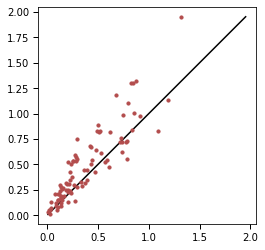

In [39]:
from scipy.stats import wilcoxon

fig = plt.figure()
ax = fig.add_subplot(111)
minEV = np.inf
maxEV = -np.inf

Information_rate_Toroidal_OF = []
Information_rate_Spatial_OF = []

for rat_name, mod_name, sess_name, day_name in (('R', '1', 'OF', 'day1'),
                                                #('R', '2', 'OF', 'day1'),
                                                #('R', '3', 'OF', 'day1'),
                                                #('R', '1', 'OF', 'day2'),
                                                #('R', '2', 'OF', 'day2'),
                                                #('R', '3', 'OF', 'day2'),
                                                #('Q', '1', 'OF', ''),
                                                #('Q', '2', 'OF', ''),
                                                #('S', '1', 'OF', ''),
                                               ):            
            file_name = rat_name + '_' + mod_name + '_' + sess_name
            f = np.load('Toroidal_topology_grid_cell_data/Results/' + file_name + '_info.npz', allow_pickle = True)
            torscores = f['I_torus']
            spacescores = f['I_space']
            f.close()

            maxEV =  max(maxEV, max(np.max(torscores), np.max(spacescores)))
            minEV =  min(minEV, min(np.min(torscores), np.min(spacescores)))
            ax.scatter(spacescores, torscores, s = 10, c = colors_envs[file_name])
            p  = wilcoxon(torscores-spacescores, alternative='greater')
            print(file_name)
            print(' n: ' + str(len(torscores)) )
            print(' p: ' + str(p) )
            print('')

            Information_rate_Toroidal_OF.extend([np.mean(torscores)])
            Information_rate_Toroidal_OF.extend([np.std(torscores)/np.sqrt(len(torscores))])
            Information_rate_Spatial_OF.extend([np.mean(spacescores)])
            Information_rate_Spatial_OF.extend([np.std(spacescores)/np.sqrt(len(spacescores))])
ax.plot([minEV, maxEV], [minEV, maxEV], c='k', zorder = -5)
ax.set_xlim([minEV-(maxEV-minEV)*0.05,maxEV+(maxEV-minEV)*0.05])
ax.set_ylim([minEV-(maxEV-minEV)*0.05,maxEV+(maxEV-minEV)*0.05])
ax.set_aspect('equal', 'box')
ax.xaxis.set_tick_params(width=1, length =5)
ax.yaxis.set_tick_params(width=1, length =5)

plot_stats(Information_rate_Toroidal_OF, Information_rate_Spatial_OF,  
    Information_rate_OF_lbls, 'info', 'OF')


In [ ]:
from scipy.stats import wilcoxon

fig = plt.figure()
ax = fig.add_subplot(111)
minEV = np.inf
maxEV = -np.inf

Information_rate_Toroidal_C = []
Information_rate_Spatial_C = []

for rat_name, mod_name, sess_name, day_name in (('R', '1', 'WW', 'day1'),
                                                ('R', '2', 'WW', 'day1'),
                                                ('R', '3', 'WW', 'day1'),
                                                ('Q', '1', 'WW', ''),
                                                ('Q', '2', 'WW', ''),
                                                ('S', '1', 'WW', ''),
                                               ):            
            file_name = rat_name + '_' + mod_name + '_' + sess_name
            f = np.load('Toroidal_topology_grid_cell_data/Results/' + file_name + '_info.npz', allow_pickle = True)
            torscores = f['I_torus']
            spacescores = f['I_space']
            f.close()

            maxEV =  max(maxEV, max(np.max(torscores), np.max(spacescores)))
            minEV =  min(minEV, min(np.min(torscores), np.min(spacescores)))
            ax.scatter(spacescores, torscores, s = 10, c = colors_envs[file_name])
            p  = wilcoxon(torscores-spacescores, alternative='greater')
            print(file_name)
            print(' n: ' + str(len(torscores)) )
            print(' p: ' + str(p) )
            print('')

            Information_rate_Toroidal_C.extend([np.mean(torscores)])
            Information_rate_Toroidal_C.extend([np.std(torscores)/np.sqrt(len(torscores))])
            Information_rate_Spatial_C.extend([np.mean(spacescores)])
            Information_rate_Spatial_C.extend([np.std(spacescores)/np.sqrt(len(spacescores))])
ax.plot([minEV, maxEV], [minEV, maxEV], c='k', zorder = -5)
ax.set_xlim([minEV-(maxEV-minEV)*0.05,maxEV+(maxEV-minEV)*0.05])
ax.set_ylim([minEV-(maxEV-minEV)*0.05,maxEV+(maxEV-minEV)*0.05])
ax.set_aspect('equal', 'box')
ax.xaxis.set_tick_params(width=1, length =5)
ax.yaxis.set_tick_params(width=1, length =5)
plot_stats(Information_rate_Toroidal_C, Information_rate_Spatial_C,  
    Information_rate_C_lbls, 'info', 'C')


In [ ]:
###################### histogram information content SWS

import h5py
import numpy as np 
from ripser import Rips, ripser
from sklearn import preprocessing
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from scipy.sparse import coo_matrix
from scipy.linalg import eigh
from scipy.sparse.linalg import lsmr
from datetime import datetime 
import time
import sys
import numba
import matplotlib
import matplotlib.pyplot as plt
from utils import *

rat_names = ['roger', 'quentin']
#rat_names = ['quentin']
mod_names = ['mod1', 'mod2', 'mod3']
sess_names = ['sws']
#LAMs = [10]#,10,100,1000]
Lams = np.array([1,10,100,1000])
Lams = np.sqrt(Lams).astype(int)

fig = plt.figure()
ax = fig.add_subplot(111)
minEV = np.inf
maxEV = -np.inf
colors_envs['roger_mod1_box_rec2'] = [[0.7,0.3,0.3]]
colors_envs['roger_mod2_box_rec2'] = [[0.7,0.7,0]]
colors_envs['roger_mod3_box_rec2'] = [[0.7,0.,0.7]]

lins = np.linspace(0,2.5,10)#np.arange(0.0,4,0.25)
print(lins)
numbins = len(lins)
width = (lins[1]-lins[0])/2
b1_max = -np.inf

torscoresall = []
spacescoresall = []
nils = 0 
j = 0
I_mean =  np.zeros(4)
for rat_name, mod_name, sess_name, day_name in (('R', '1', 'REM', 'day2'),
                                                ('R', '2', 'REM', 'day2'),
                                                ('R', '3', 'REM', 'day2'),
                                                ('R', '1', 'SWS', 'day2'),
                                                ('R', '2', 'SWS', 'day2'),
                                                ('R', '3', 'SWS', 'day2'),
                                                ('Q', '1', 'REM', ''),
                                                ('Q', '2', 'REM', ''),
                                                ('Q', '1', 'SWS', ''),
                                                ('Q', '2', 'SWS', ''),
                                                ('S', '1', 'REM', ''),
                                                ('S', '1', 'SWS', '')
                                                ):
        file_name = rat_name + '_' + mod_name + '_' + sess_name
        f = np.load('Toroidal_topology_grid_cell_data/Results/' + file_name + '_info.npz', allow_pickle = True)
        torscores = f['I_torus']
        f.close()
        maxEV =  max(maxEV, np.max(torscores))
        minEV =  min(minEV, np.min(torscores))
        i1 = np.digitize(torscores, lins)-1
        b1 = np.bincount(i1,minlength = numbins)/len(torscores,)
        b1_max = max(b1_max,np.max(b1))
        ax.plot(lins + width, b1,  alpha = 0.7, c = colors_envs[file_name][0], lw = 3)
        I_mean[j] = np.mean(I_torus_sws_shuf)
        j += 1


b1_max = 0.4

ax.plot([np.mean(I_mean),np.mean(I_mean)], [0, b1_max], c = 'k', ls = '--', lw = 1 )

ax.set_ylim([0,b1_max])
ax.set_xlim([np.min(lins),np.max(lins)])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0,0.5,1,1.5,2,2.5])
ax.set_xticklabels(('','','','','',''))
ax.xaxis.set_tick_params(width=1, length =5)
ax.set_yticks([0,0.1,0.2,0.3])
ax.set_yticklabels(('','','',''))
ax.yaxis.set_tick_params(width=1, length =5)            


In [ ]:
###################### histogram information content SWS

import h5py
import numpy as np 
from ripser import Rips, ripser
from sklearn import preprocessing
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from scipy.sparse import coo_matrix
from scipy.linalg import eigh
from scipy.sparse.linalg import lsmr
from datetime import datetime 
import time
import sys
import numba
import matplotlib
import matplotlib.pyplot as plt
from utils import *

rat_names = ['roger', 'quentin']
#rat_names = ['quentin']
mod_names = ['mod1', 'mod2', 'mod3']
sess_names = ['sws']
#LAMs = [10]#,10,100,1000]
Lams = np.array([1,10,100,1000])
Lams = np.sqrt(Lams).astype(int)

fig = plt.figure()
ax = fig.add_subplot(111)
minEV = np.inf
maxEV = -np.inf
colors_envs['roger_mod1_box_rec2'] = [[0.7,0.3,0.3]]
colors_envs['roger_mod2_box_rec2'] = [[0.7,0.7,0]]
colors_envs['roger_mod3_box_rec2'] = [[0.7,0.,0.7]]

lins = np.linspace(0,2.5,10)#np.arange(0.0,4,0.25)
print(lins)
numbins = len(lins)
width = (lins[1]-lins[0])/2
b1_max = -np.inf

torscoresall = []
spacescoresall = []
nils = 0 
j = 0
I_mean =  np.zeros(4)
for rat_name, mod_name, sess_name, day_name in (('R', '1', 'REM', 'day2'),
                                                ('R', '2', 'REM', 'day2'),
                                                ('R', '3', 'REM', 'day2'),
                                                ('Q', '1', 'REM', ''),
                                                ('Q', '2', 'REM', ''),
                                                ('S', '1', 'REM', ''),
                                                ):
        file_name = rat_name + '_' + mod_name + '_' + sess_name
        f = np.load('Toroidal_topology_grid_cell_data/Results/' + file_name + '_info.npz', allow_pickle = True)
        torscores = f['I_torus']
        f.close()
        maxEV =  max(maxEV, np.max(torscores))
        minEV =  min(minEV, np.min(torscores))
        i1 = np.digitize(torscores, lins)-1
        b1 = np.bincount(i1,minlength = numbins)/len(torscores,)
        b1_max = max(b1_max,np.max(b1))
        ax.plot(lins + width, b1,  alpha = 0.7, c = colors_envs[file_name][0], lw = 3)
        I_mean[j] = np.mean(I_torus_sws_shuf)
        j += 1


b1_max = 0.4

ax.plot([np.mean(I_mean),np.mean(I_mean)], [0, b1_max], c = 'k', ls = '--', lw = 1 )

ax.set_ylim([0,b1_max])
ax.set_xlim([np.min(lins),np.max(lins)])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0,0.5,1,1.5,2,2.5])
ax.set_xticklabels(('','','','','',''))
ax.xaxis.set_tick_params(width=1, length =5)
ax.set_yticks([0,0.1,0.2,0.3])
ax.set_yticklabels(('','','',''))
ax.yaxis.set_tick_params(width=1, length =5)            
